In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18,12)
mpl.rcParams['axes.grid'] = False
sns.set_style('whitegrid')

import torch
import torch.nn as nn

In [38]:
# Upload the data frame into the notebook
data_frame = pd.read_csv('Data/learn_noise_siso2.csv')
test_frame = pd.read_csv('Data/test_jump_siso2.csv')
prediction_test_frame = pd.read_csv('Data/test_jump_siso2.csv', nrows=6)

In [39]:
display(data_frame.head(5))

,Y,U
0,0.000000,-0.709580
1,0.000000,2.414775
2,-2.398553,-0.127366
3,-1.391219,-0.705401
4,10.120519,3.228365


In [40]:
# Defining a batch size based on the data
batch_size = 100

# Split the dataset into different batches
batch_data = np.array_split(data_frame, int(data_frame.shape[0]/batch_size))

# Shifting batch number 5 to the end to be used as a test data
# batch_data.append(batch_data.pop(1))

# Combining all the batches to form a single dataset
df = pd.DataFrame(np.concatenate(batch_data),columns=list(data_frame.columns))

/opt/anaconda3/envs/rnn4nds/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [41]:
batch_data

[            Y         U
 0    0.000000 -0.709580
 1    0.000000  2.414775
 2   -2.398553 -0.127366
 3   -1.391219 -0.705401
 4   10.120519  3.228365
 ..        ...       ...
 95   9.453566 -3.223227
 96   5.709890 -1.572641
 97   1.887747  0.456138
 98   4.855706  2.215907
 99  28.642398 -5.540415
 
 [100 rows x 2 columns],
             Y         U
 100  5.752777  0.460827
 101  0.148571  0.710389
 102  0.305527  0.972343
 103  6.656395  2.737168
 104  6.509414 -3.030056
 ..        ...       ...
 195 -3.004009  0.002685
 196 -2.111992  0.749498
 197  3.487160  2.439646
 198 -1.363261  0.889307
 199 -0.817065 -1.026607
 
 [100 rows x 2 columns],
             Y         U
 200  2.489390 -1.408547
 201  2.878575 -1.045814
 202  3.760987  1.539678
 203 -1.280329 -0.031454
 204 -0.763387  0.334811
 ..        ...       ...
 295  1.525532  0.702789
 296  8.184531 -2.914452
 297  2.953566  0.105251
 298  2.237386 -1.415965
 299  4.276298  1.571263
 
 [100 rows x 2 columns],
              Y    

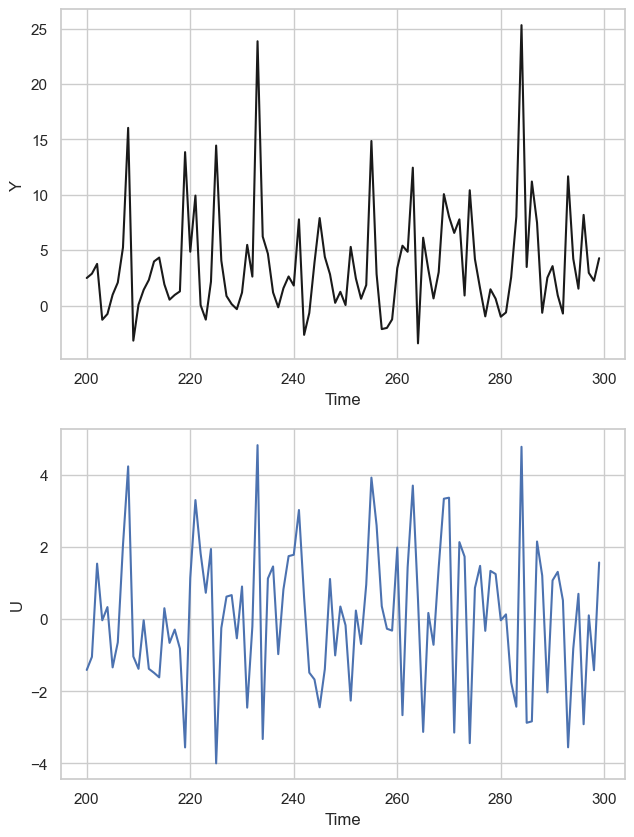

In [42]:
# Plotting the test data batch
fig = plt.figure(figsize=(16,10))

batch_no = 3

plt.subplot(2, 2, 1)
plt.plot(batch_data[batch_no-1]['Y'],'k')
plt.xlabel('Time')
plt.ylabel('Y')


plt.subplot(2, 2, 3)
plt.plot(batch_data[batch_no-1]['U'],'b')
plt.xlabel('Time')
plt.ylabel('U')


plt.show()

In [43]:
# Define a test size
test_size = batch_size

y = df.values.astype(float)
y_test = test_frame.values.astype(float)
y_pred_test = prediction_test_frame.values.astype(float)

# Create train and test sets
train_set = y
test_set = y_test
pred_test_set = y_pred_test
print(test_set)
# Convert train set into a torch tensor
train_set = torch.FloatTensor(train_set).view(-1,df.shape[1])
test_set = torch.FloatTensor(test_set).view(-1,df.shape[1])
pred_test_set= torch.FloatTensor(pred_test_set).view(-1,df.shape[1])

In [44]:
# Creating a function to generate the input data for the lstm 
def input_data(seq,ws):
    
    inp_data = []
    
    for bat in range(0,train_set.shape[0],batch_size):
        
        bat_seq = seq[bat:bat+101]
        l = len(bat_seq)
        
        window = []
        label = []
        
        for i in range(l-ws):
        
            window = bat_seq[i:i+ws]
            label = bat_seq[i+ws:i+ws+1,:2]

            inp_data.append((window,label))
        
    return inp_data

In [45]:
# Defining a window size for prediction
window_size = 1
train_data = input_data(train_set,window_size)

In [46]:
from classy import LSTMModel

# Creating a model instance, loss function and the optimizer
model = LSTMModel(input_size=2,hidden_size_1=50,hidden_size_2=50,out_size=1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [47]:
display(model)

LSTMModel(
  (lstm_1): LSTM(2, 50)
  (lstm_2): LSTM(50, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [48]:
display(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [49]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 10000
   200
   200
 10000
 10000
   200
   200
    50
     1
______
 31251


In [50]:
# Set the number of epochs

epochs = 100

for epoch in range(epochs):
    
    # Running each batch separately 
    
    for bat in range(0,1400,100):
    
        for seq,label in train_data[bat:bat+100]:
            
            # set the optimization gradient to zero

            optimizer.zero_grad()
            
            # initialize the hidden states

            model.hidden_1 = (torch.zeros(1,1,model.hidden_size_1),
                            torch.zeros(1,1,model.hidden_size_1))

            model.hidden_2 = (torch.zeros(1,1,model.hidden_size_2),
                            torch.zeros(1,1,model.hidden_size_2))
            
            # Make predictions on the current sequence

            y_pred = model(seq)
            
            # Compute the loss

            loss = criterion(y_pred, label)
            
            # Perform back propogation and gradient descent

            loss.backward()

            optimizer.step()

    if epoch%10 == 0:

        print(f'Epoch: {epoch} Loss: {loss.item():10.8f}')

/opt/anaconda3/envs/rnn4nds/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Loss: 3.13365388
Epoch: 10 Loss: 3.95994306
Epoch: 20 Loss: 4.20138168
Epoch: 30 Loss: 4.29313374
Epoch: 40 Loss: 4.25492620
Epoch: 50 Loss: 4.21747160
Epoch: 60 Loss: 4.21267986
Epoch: 70 Loss: 4.21698904
Epoch: 80 Loss: 4.23268270
Epoch: 90 Loss: 4.26369858


In [51]:
future = 100

# Set the model to evaluation mode

model.eval()

preds = [test_set[0,:1].reshape(-1,1)]
print(test_set[0,:1])
print(preds)
for i in range(future-1):
    
    seq = test_set[i].reshape(-1,2)
    
    # Informing PyTorch that I am no longer interested in the gradients
    
    with torch.no_grad():
        
        # Initialize the hidden states
        
        model.hidden_1 = (torch.zeros(1,1,model.hidden_size_1),
                        torch.zeros(1,1,model.hidden_size_1))
        model.hidden_2 = (torch.zeros(1,1,model.hidden_size_2),
                        torch.zeros(1,1,model.hidden_size_2))
        
        preds.append(model(seq))
print(preds)       

tensor([0.])
[tensor([[0.]])]
[tensor([[0.]]), tensor([[2.0877]]), tensor([[2.0877]]), tensor([[1.3792]]), tensor([[1.3792]]), tensor([[1.7098]]), tensor([[1.7107]]), tensor([[1.6096]]), tensor([[1.6501]]), tensor([[1.6975]]), tensor([[1.6781]]), tensor([[1.6601]]), tensor([[1.6759]]), tensor([[1.6801]]), tensor([[1.6726]]), tensor([[1.6723]]), tensor([[1.6759]]), tensor([[1.6752]]), tensor([[1.6738]]), tensor([[1.6744]]), tensor([[1.6749]]), tensor([[1.6745]]), tensor([[1.6744]]), tensor([[1.6746]]), tensor([[1.6746]]), tensor([[1.6745]]), tensor([[1.6745]]), tensor([[1.6745]]), tensor([[1.6745]]), tensor([[1.6745]]), tensor([[1.6745]]), tensor([[1.6745]]), tensor([[1.6745]]), tensor([[1.6745]]), tensor([[1.6745]]), tensor([[1.6745]]), tensor([[1.6745]]), tensor([[1.6745]]), tensor([[1.6745]]), tensor([[1.6745]]), tensor([[1.6745]]), tensor([[1.6745]]), tensor([[1.6745]]), tensor([[1.6745]]), tensor([[1.6745]]), tensor([[1.6745]]), tensor([[1.6745]]), tensor([[1.6745]]), tensor([[1.67

In [52]:
predictions = np.array([pred.numpy() for pred in preds]).reshape(-1,1)
true_values = np.array(test_set[:,:1])

Text(0, 0.5, 'x1')

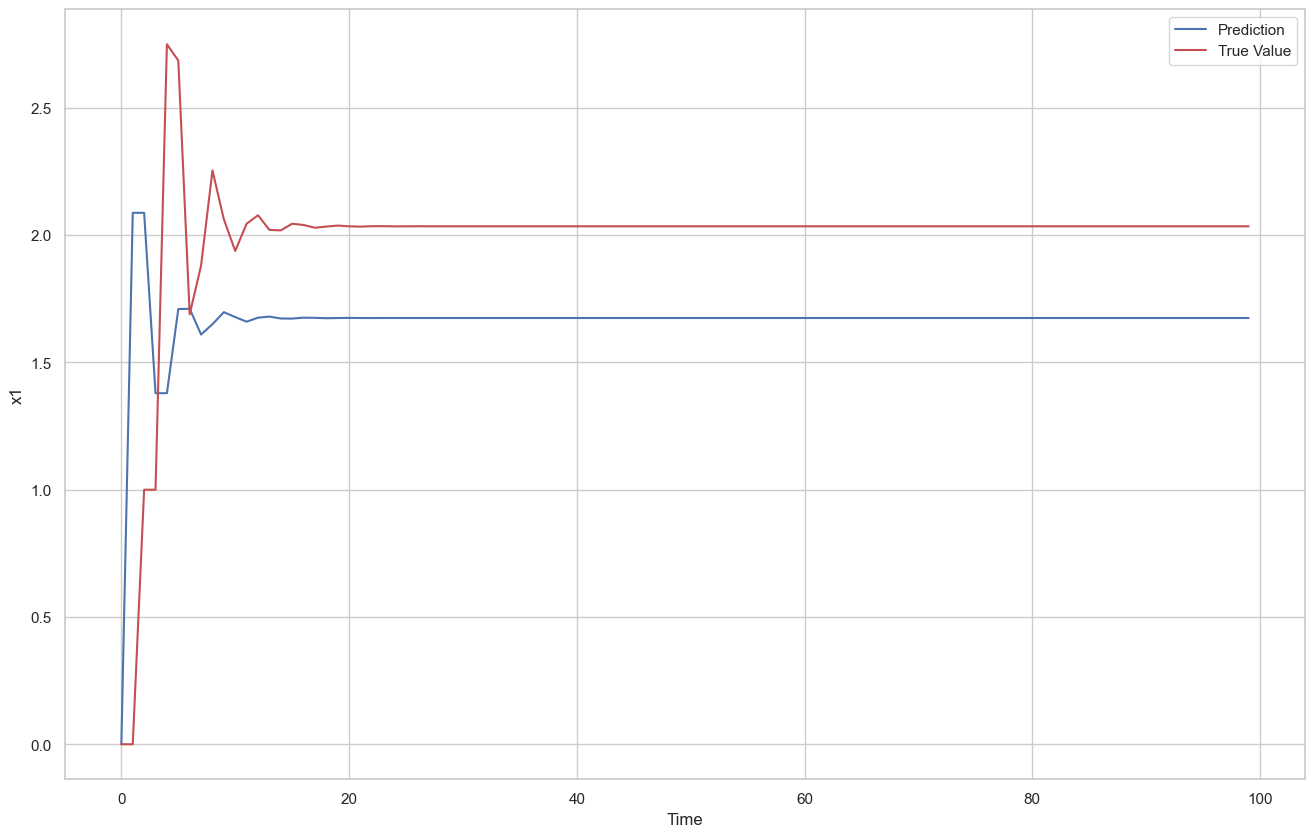

In [53]:
fig = plt.figure(figsize=(16,10))

plt.plot(predictions[:,0],'b',label='Prediction')
plt.plot(true_values[:,0],'r',label='True Value')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x1')

In [54]:
RMSE = np.sqrt(np.sum(np.square((predictions - true_values[:,0])))/predictions.size)
display(RMSE)

5.00986039444963

In [ ]:
future=100

preds = [test_set[0,:1].reshape(-1,1)]
print(test_set[0,:1])
print(preds)

for i in range(future-1):
    if i < len(pred_test_set):
        seq = test_set[i].reshape(-1, 2)
    else:
        x = torch.FloatTensor(preds[-1])  # Assuming preds[-1] contains the last prediction
        y = 1.0
        seq = torch.FloatTensor([x, y]).view(-1, df.shape[1])
            
    # Check if the sequence length is greater than 0
    if seq.size(0) > 0:
        # Informing PyTorch that I am no longer interested in the gradients
        with torch.no_grad():
            # Initialize the hidden states
            model.hidden_1 = (torch.zeros(1, 1, model.hidden_size_1),
                              torch.zeros(1, 1, model.hidden_size_1))
            model.hidden_2 = (torch.zeros(1, 1, model.hidden_size_2),
                              torch.zeros(1, 1, model.hidden_size_2))
            
            preds.append(model(seq))

In [ ]:
predictions2 = np.array([pred.numpy() for pred in preds]).reshape(-1,1)
true_values = np.array(test_set[:,:1])

In [ ]:
fig = plt.figure(figsize=(16,10))
plt.plot(predictions2[:,0],'g',label='Self predicted')
plt.plot(predictions[:,0],'b',label='Prediction')
plt.plot(true_values[:,0],'r',label='True Value')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x1')